In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# sklearn imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KDTree

# sklearn models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [2]:
path = '../data/modified/trees_first.pkl'
trees= pd.read_pickle(path)

In [3]:
trees = trees.astype({'ADR_SECTEUR':'object'})

trees_train,trees_test = train_test_split(trees,random_state=2708)

# Transform data

## Preprocessing

In [4]:
# Transforme GEOJSON data in two features
class TransformGEOJSON(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df,y=None):
        return self
    def transform(self, df):
        df_new = df.copy()
        pat = '([0-9]+.[0-9]+)'
        df_new[['latitude','longitude']] = df_new.GeoJSON.str.extractall(pat).unstack(level=1).astype('float64')
        df_new = df_new.drop('GeoJSON',axis=1)
        return df_new

# Drop features without info (1) or identifiers features
class DropuniqueCol(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        to_drop = ['ELEM_POINT_ID','CODE','NOM','GENRE','GENRE_DESC','CATEGORIE','CATEGORIE_DESC','BIEN_REFERENCE','SOUS_CATEGORIE','CODE_PARENT']
        df_new = df.drop(to_drop,axis=1)
        return df_new

# Drop Na features     
class DropNaWithSaveCol(BaseEstimator,TransformerMixin):
    def __init__(self,na_threshold=0.5):
        self.threshold = na_threshold
    def fit(self, df):
        na = df.isna().sum().div(len(df)).sort_values(ascending=False)
        self.col_na = na.where(na>=self.threshold).dropna().index
        return self
    def transform(self, df):
        check_is_fitted(self, ['col_na'])
        df_new= df.drop(self.col_na,axis=1)
        return df_new


    


## Creating simple custom imputer

In [5]:
class InputMissingValues(BaseEstimator,TransformerMixin):
    
    def __init__(self,to_use=True):
        self.to_use=to_use
        self.errors = []
        
    def fit(self, df,y=None):
        self.most_freq_genre = df.GENRE_BOTA.mode().values[0]
        self.gerne_espece = df.groupby('GENRE_BOTA').ESPECE.value_counts(dropna=False).sort_values(ascending=False)
        self.fill_with = 'ND'
        self.errors = []
        return self
    
    def transform(self, df):
        if self.to_use:
            df_new = df.copy()
            df_new['COLLECTIVITE'] = df_new['COLLECTIVITE'].fillna(self.fill_with)
            df_new['STADEDEDEVELOPPEMENT'] = df_new['COLLECTIVITE'].fillna(self.fill_with)
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].fillna(self.most_freq_genre)
            
            liste_ind = []
            liste_replace = []
            
            for ind,row in df_new.iterrows():
                if isinstance(row['ESPECE'], float):
                    liste_ind.append(ind)
                    genre = row['GENRE_BOTA']
                    if genre == 'Poncinos':
                        self.errors.append((ind,row))
                    # check database for most common species accociated with gern
                    species_replace = self.gerne_espece.xs(genre,level=0).idxmax()
                    if isinstance(species_replace, float):
                        species_replace = self.fill_with
                    liste_replace.append(species_replace)
            if len(liste_ind) != 0:
                for ind,replace in zip(liste_ind,liste_replace):
                    df_new.loc[ind,'ESPECE'] = replace
            return  df_new
        else:
            return df

## Preprocess pipeline

In [6]:
preprocess_pipeline = Pipeline([("geo", TransformGEOJSON()),
                                ('dropuni',DropuniqueCol()),
                                ('na',DropNaWithSaveCol()),
                               ('fillna',InputMissingValues())])

## Feature add

In [7]:
# Create Bio features

class Bio(BaseEstimator,TransformerMixin):
    def __init__(self,to_use=True):
        self.to_use = to_use
    def fit(self, df,y=None):
        return self
    def transform(self,df):
        if self.to_use:
            df_new = df.copy()
            df_new['ESPECE'] = df_new['ESPECE'].map(str).replace('nan',' ')
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].map(str).replace('nan',' ')
            df_new['BIO'] = df_new['GENRE_BOTA'] + " " + df['ESPECE']
            df_new = df_new.drop(['GENRE_BOTA','ESPECE'],axis=1)
            return df_new
        else:
            return df

feature_adder = Pipeline(['Bio',Bio()])

## Columns Transformer 

In [8]:
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')
numerical_transformer = StandardScaler()

transformer = ColumnTransformer(
[("num_trans", numerical_transformer, make_column_selector(dtype_exclude="object")),
("cat_trans", categorical_transformer, make_column_selector(dtype_include='object'))])

## Transform Train

In [9]:
predictor_train = trees_train.drop('ANNEEDEPLANTATION',axis=1)

In [10]:
annee_train = trees_train.ANNEEDEPLANTATION

In [11]:
processed_train_predictors = preprocess_pipeline.fit_transform(predictor_train)
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Ville de Grenoble,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Grenoble Alpes Métropole,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Ville de Grenoble,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Ville de Grenoble,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Ville de Grenoble,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Ville de Grenoble,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Ville de Grenoble,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Grenoble Alpes Métropole,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Ville de Grenoble,Ville de Grenoble,5.737468,45.176643


In [12]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC     0
CODE_PARENT_DESC        0
ADR_SECTEUR             0
GENRE_BOTA              0
ESPECE                  0
STADEDEDEVELOPPEMENT    0
COLLECTIVITE            0
latitude                0
longitude               0
dtype: int64

## Creating custom imputer based on KDtree

In [78]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [79]:
test_pos = processed_train_predictors[['latitude','longitude']]

In [80]:
na = processed_train_predictors.isna().sum(axis=1).values
na[na>1] = 1

In [81]:
test_pos['na'] = na

/tmp/ipykernel_43516/983512539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pos['na'] = na


In [82]:
tree = KDTree(test_pos)

In [83]:
test_pos[test_pos.na == 1]

,latitude,longitude,na
23300,5.741641,45.198570,1
26062,5.705979,45.162356,1
23680,5.734933,45.176984,1
29119,5.735284,45.163227,1
31231,5.731959,45.177532,1
...,...,...,...
26738,5.706475,45.203417,1
8838,5.736906,45.163398,1
23664,5.736701,45.161216,1
28946,5.735231,45.164474,1


In [84]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [85]:
list_sddev = processed_train_predictors.STADEDEDEVELOPPEMENT.value_counts().index.to_list()

In [86]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC        0
CODE_PARENT_DESC           0
ADR_SECTEUR                0
GENRE_BOTA                17
ESPECE                  1143
STADEDEDEVELOPPEMENT    1610
COLLECTIVITE               0
latitude                   0
longitude                  0
dtype: int64

In [87]:
for row in processed_train_predictors.itertuples():
    if row.STADEDEDEVELOPPEMENT not in list_sddev :
        i = row.Index
        test_query = test_pos[test_pos.index==i].values.reshape(1,-1)        
        query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)
        list_query=[]
        for ind in query_ind:
            list_query.append(processed_train_predictors.iloc[ind])
        df_query = pd.concat(list_query)
        df_query['distance']=query_dist.reshape(-1,1)
            

In [88]:
processed_train_predictors.isna().sum(axis=1).sort_values(ascending=False)

23015    3
23503    3
22865    3
22860    3
23501    3
        ..
16640    0
25463    0
7694     0
23981    0
2455     0
Length: 22693, dtype: int64

In [278]:
test_query

,latitude,longitude,na
23300,5.741641,45.19857,1


In [295]:
test_query = test_pos[test_pos.index==23015].values.reshape(1,-1)        

In [296]:
test_query

array([[ 5.71987004, 45.17990662,  1.        ]])

In [297]:
test_pos[test_pos.index==23015]  
processed_train_predictors[processed_train_predictors.index==23015]

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
23015,Arbre d'espaces ouverts,R Cdt de Reynies,4,NaN,NaN,NaN,Grenoble Alpes Métropole,5.71987,45.179907


In [301]:
query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)

In [302]:
query_ind

array([[22676, 22663, 17206, 21915, 17230,  9178,  9222, 13912, 11818,
        11360,   710, 20008, 11093,  5919,   556,  7599,  8858,  5426,
        11507, 11965, 22601, 15923,  7696,  2202,  4756, 14797,  8890,
        11620,  9633,  6008]])

In [303]:
list_query=[]
list_dist=[]
for dist,i in zip(query_dist,query_ind):
    list_query.append(processed_train_predictors.iloc[i])
df_query = pd.concat(list_query)

In [304]:
df_query['distance']=query_dist.reshape(-1,1)

In [319]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT')

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude,distance
13639,Arbre d'espaces ouverts,Aire de jeux butte 04,6,Quercus,NaN,Arbre vieillissant,Ville de Grenoble,5.735711,45.164299,0.000453
8488,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736137,45.164063,0.000936
6245,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736125,45.163998,0.000953
29586,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736176,45.164036,0.000982
18708,Arbre d'espaces ouverts,R du Trident 12 et 13,6,Prunus,NaN,Arbre jeune,Ville de Grenoble,5.735352,45.165433,0.000998
29862,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736173,45.163963,0.001012
13971,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736230,45.164075,0.001017
14821,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736227,45.164002,0.001043
863,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736280,45.164042,0.001076
24168,Arbre d'espaces ouverts,Butte n 04 toboggan,6,Acer,NaN,Arbre adulte,Ville de Grenoble,5.736330,45.164081,0.001110


In [322]:
mean = df_query.dropna(subset='STADEDEDEVELOPPEMENT').groupby('STADEDEDEVELOPPEMENT').distance.mean()

In [326]:
nb = df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts()

In [327]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts().mul(mean).div(nb)

Arbre adulte          0.001029
Arbre jeune           0.000998
Arbre vieillissant    0.000453
dtype: float64

In [76]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC        0
CODE_PARENT_DESC           0
ADR_SECTEUR                0
GENRE_BOTA                17
ESPECE                  1143
STADEDEDEVELOPPEMENT    1610
COLLECTIVITE               0
latitude                   0
longitude                  0
dtype: int64

# Modelisation

In [129]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10],
           'model':[model_1]} 
model_2 = DecisionTreeRegressor()
param_2 = {'f_adder_1__to_use':[True],
           'model__min_samples_leaf':[1],
           'model':[model_2]} 
model_3 = SVR()
param_3 = {'f_adder_1__to_use':[True],
           'model__C':[10],
           'model':[model_3]} 
model_4 = LinearRegression()
param_4 = {'f_adder_1__to_use':[True],
           'model':[model_4]} 
model_5 = Lasso()
param_5 = {'f_adder_1__to_use':[True],
           'model__alpha':[10],
           'model':[model_5]} 

In [130]:
pipe = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(False)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])
params_list = [param_1,param_2,param_3,param_4,param_5]

grid_search = GridSearchCV(pipe,params_list,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [131]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__n_estimators,param_model__min_samples_leaf,param_model__C,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.703233,0.094753,0.042651,0.001810,True,RandomForestRegressor(n_estimators=10),10,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': RandomFor...",-55.273448,-51.591538,-56.229044,-58.914108,-55.898753,-55.581378,2.351209,1
2,21.943532,2.485970,2.043622,0.044909,True,SVR(),NaN,NaN,10,NaN,"{'f_adder_1__to_use': True, 'model': SVR(), 'm...",-72.460598,-74.644943,-76.247952,-73.482846,-77.235632,-74.814394,1.746973,2
3,0.938583,0.061553,0.039938,0.009501,True,LinearRegression(),NaN,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': LinearReg...",-76.748386,-78.371086,-70.590779,-77.725830,-75.721593,-75.831535,2.769690,3
1,0.883185,0.044554,0.029427,0.001278,True,DecisionTreeRegressor(),NaN,1,NaN,NaN,"{'f_adder_1__to_use': True, 'model': DecisionT...",-69.725931,-82.792245,-85.722846,-72.868444,-76.445571,-77.511007,5.976985,4
4,0.154307,0.005421,0.031108,0.002142,True,Lasso(),NaN,NaN,NaN,10,"{'f_adder_1__to_use': True, 'model': Lasso(), ...",-312.989950,-319.720947,-317.132212,-321.213498,-320.278011,-318.266924,2.965636,5


In [132]:
best_model = grid_search.best_params_

In [133]:
best_pipe = grid_search.best_estimator_

In [134]:
best_pipe.score(processed_train_predictors,annee_train)

0.9723844696905215

## Check parameters of the forest => tree depth, max features

In [135]:
liste_depth=[]
for estimator in best_pipe.named_steps['model'].estimators_:
    liste_depth.append(estimator.get_depth())

In [136]:
liste_max_features=[]
for estimator in best_pipe.named_steps['model'].estimators_:
    liste_max_features.append(estimator.max_features_)

In [137]:
print(f'Mean depth : {sum(liste_depth)/len(liste_depth)}')
print(f'Mean Max Features : {sum(liste_max_features)/len(liste_max_features)}')

Mean depth : 101.1
Mean Max Features : 1787.0


In [19]:
# check errors in model
# pipe.named_steps['custom_simple_imputer'].errors

# Test of best model on test dataset

In [24]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [25]:
process_test_predictors = preprocess_pipeline.transform(test_predictors)

In [26]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

48.552785194976856

In [27]:
best_pipe.score(process_test_predictors,annee_test)

0.8496354031971977

# Prediction on na values

In [35]:
path_first_na = '../data/modified/trees_first_na.pkl'
trees_na= pd.read_pickle(path_first_na)

In [36]:
trees_na

,ELEM_POINT_ID,CODE,NOM,GENRE,GENRE_DESC,CATEGORIE,CATEGORIE_DESC,SOUS_CATEGORIE,SOUS_CATEGORIE_DESC,CODE_PARENT,...,COURRIER,IDENTIFIANTPLU,TYPEIMPLANTATIONPLU,INTITULEPROTECTIONPLU,ANNEEABATTAGE,ESSOUCHEMENT,DIAMETREARBRE,CAUSEABATTAGE,COLLECTIVITE,GeoJSON
1075,39588,ESP38596,ESP38596,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7033870348283..."
1076,39589,ESP38597,ESP38597,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7034657665144..."
1077,39590,ESP38598,ESP38598,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7199743332099..."
1088,43402,ESP39987,ESP39987,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7139485923092..."
1089,43403,ESP39988,ESP39988,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7138453760140..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31603,46019,ESP41553,ESP41553,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7358259784285..."
31604,46020,ESP41554,ESP41554,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7356836831762..."
31605,46021,ESP41555,ESP41555,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7362096829728..."
31606,46022,ESP41556,ESP41556,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7355397923023..."


In [37]:
trees_na = trees_na.astype({'ADR_SECTEUR':'object'})

In [38]:
trees_na = trees_na.drop(['ANNEEDEPLANTATION'],axis=1)

In [39]:
processed_na = preprocess_pipeline.transform(trees_na)

In [40]:
y = best_pipe.predict(processed_na)

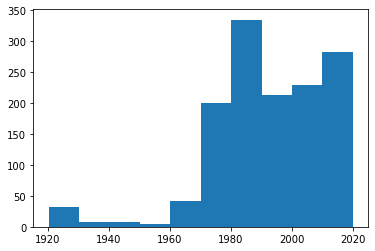

In [41]:
plt.hist(y);

# Hyperparameter tuning for random forest regressor

## Hyperparameter tuning

### Tuning 1

In [42]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,50,100],
           'model__min_samples_leaf':[1,10,20],
           'model':[model_1]} 

In [43]:
pipe = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(False)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])

In [44]:
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [45]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,73.549665,0.888205,0.094283,0.024679,True,RandomForestRegressor(),1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-45.689418,...,-46.476998,-52.168887,-50.253917,-51.575257,-55.348494,-43.834812,-52.760033,-49.461154,3.839686,1
1,35.854240,0.488195,0.056983,0.006436,True,RandomForestRegressor(),1,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-46.535256,...,-47.368656,-51.740271,-50.477175,-52.678627,-54.137998,-44.747684,-52.507693,-50.029548,3.466371,2
0,7.318377,0.199720,0.026693,0.000584,True,RandomForestRegressor(),1,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-49.728652,...,-48.743230,-58.706999,-52.725734,-56.613812,-59.448277,-50.812340,-55.977563,-53.486967,3.925466,3
5,38.295121,0.641630,0.064765,0.001355,True,RandomForestRegressor(),10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-79.710564,...,-85.201369,-86.179886,-87.262722,-83.915259,-86.024146,-81.164164,-86.367735,-84.391232,2.282158,4
4,19.464535,0.223591,0.042881,0.001359,True,RandomForestRegressor(),10,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-79.491264,...,-86.234561,-86.162633,-87.748370,-84.867898,-86.841107,-81.642770,-87.684566,-84.941275,2.523042,5
3,3.932067,0.114313,0.024483,0.000339,True,RandomForestRegressor(),10,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-84.233595,...,-87.638856,-88.293798,-92.253424,-86.030482,-90.457726,-84.148528,-91.368617,-87.940742,2.825795,6
8,26.307022,2.878430,0.048598,0.008715,True,RandomForestRegressor(),20,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-104.508596,...,-114.404165,-108.460723,-109.149281,-104.081243,-110.605057,-105.701230,-111.517915,-108.272666,3.356511,7
7,13.996172,0.131000,0.038331,0.000279,True,RandomForestRegressor(),20,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-105.694532,...,-115.118370,-108.572229,-109.037306,-105.176333,-110.793198,-106.088514,-111.872300,-108.570589,3.265585,8
6,2.852742,0.042636,0.023814,0.001040,True,RandomForestRegressor(),20,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-108.445381,...,-117.716570,-111.477767,-114.408051,-105.744353,-116.046002,-107.914291,-116.659833,-111.492876,4.230345,9


### Tuning 2

In [46]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,50],
           'model__min_samples_leaf':[1,10,25],
           'model__max_features':['sqrt','log2'],
           'model__ccp_alpha':[0,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [47]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [48]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.899151,0.056412,0.044375,0.004054,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,1,25,...,-43.613373,-45.373496,-43.959812,-45.275151,-53.313506,-43.109625,-46.926294,-45.033860,3.122150,8
1,7.581982,0.038295,0.062658,0.001709,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,1,50,...,-42.821042,-47.366137,-43.070708,-43.708484,-53.388052,-41.420721,-46.021206,-44.370679,3.668909,3
2,0.390633,0.010904,0.027959,0.000424,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,10,25,...,-182.012296,-196.633689,-178.162831,-185.395154,-185.924011,-187.435913,-186.134108,-185.845028,4.560098,23
3,0.676670,0.011864,0.035136,0.000880,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,10,50,...,-185.122954,-188.803753,-179.162997,-179.946200,-192.452973,-185.192594,-186.320517,-185.611980,5.264832,21
4,0.228330,0.011014,0.025416,0.000353,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,25,25,...,-253.804556,-273.568786,-248.920845,-251.715095,-252.143622,-250.448640,-248.178811,-255.002912,9.246107,30


In [49]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
19,-43.632181,50,0.001,1,log2
7,-44.043868,50,0,1,log2
1,-44.370679,50,0,1,sqrt
13,-44.386378,50,0.001,1,sqrt
6,-44.657804,25,0,1,log2
31,-44.668025,50,0.01,1,log2
12,-44.973880,25,0.001,1,sqrt
0,-45.033860,25,0,1,sqrt
25,-45.420770,50,0.01,1,sqrt
18,-45.483580,25,0.001,1,log2


### Tuning 3

In [50]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,100,150],
           'model__min_samples_leaf':[1,2,3,4,5],
           'model__max_features':['sqrt'],
           'model__ccp_alpha':[0,0.0001,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [51]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [52]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.866472,0.047080,0.043055,0.002821,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,25,...,-46.050855,-48.096415,-43.864379,-44.491618,-55.837473,-43.245987,-47.343865,-46.038317,3.769846,11
1,15.159088,0.152710,0.102433,0.001715,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,100,...,-42.195554,-45.217752,-43.114907,-43.481129,-51.544299,-41.152777,-46.051849,-43.768014,3.149677,4
2,23.086218,0.252738,0.143999,0.001779,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,150,...,-42.375042,-44.922869,-43.221807,-42.633312,-51.941746,-40.925220,-45.491847,-43.622133,3.236646,1
3,1.244010,0.043227,0.036489,0.009810,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,25,...,-102.659956,-107.544876,-98.358689,-98.953867,-107.922207,-105.822163,-101.975737,-103.341507,3.853353,25
4,4.600943,0.050341,0.071452,0.000552,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,100,...,-101.883510,-107.907461,-99.119828,-95.464838,-106.945265,-101.086865,-100.812826,-101.728323,3.982783,18


In [53]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
2,-43.622133,150,0,1,sqrt
17,-43.668092,150,0.0001,1,sqrt
32,-43.711409,150,0.001,1,sqrt
1,-43.768014,100,0,1,sqrt
31,-44.096015,100,0.001,1,sqrt
16,-44.175855,100,0.0001,1,sqrt
47,-44.721539,150,0.01,1,sqrt
46,-44.801302,100,0.01,1,sqrt
30,-45.327070,25,0.001,1,sqrt
15,-45.386740,25,0.0001,1,sqrt


### Tuning 4 Pruning the tree 

Fixing min sample leaf > 1 and limiting the depth of the tree 

In [112]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[100,150,250],
           'model__min_samples_leaf':[5,10],
           'model__max_features':['sqrt'],
           'model__ccp_alpha':[0,0.0001,0.001,0.01,0.1],
           'model__max_depth':[100,125,150],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [113]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [114]:
grid_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
24,2.233155,0.049179,0.062389,0.004283,True,"RandomForestRegressor(ccp_alpha=0.0001, max_de...",0.0001,125,sqrt,5,...,-144.755206,-149.759493,-138.586995,-138.406595,-148.182518,-142.623802,-143.381212,-143.863693,4.575083,1
48,2.174089,0.028968,0.062888,0.003621,True,"RandomForestRegressor(ccp_alpha=0.0001, max_de...",0.001,150,sqrt,5,...,-144.261119,-150.196009,-138.379391,-137.354134,-148.121489,-143.053360,-142.889813,-143.915437,4.376749,2
13,3.409051,0.162359,0.083289,0.006145,True,"RandomForestRegressor(ccp_alpha=0.0001, max_de...",0,150,sqrt,5,...,-145.149104,-151.096298,-140.467068,-136.991673,-145.563314,-141.306612,-143.305758,-143.940475,4.701975,3
8,5.478208,0.128866,0.128984,0.010266,True,"RandomForestRegressor(ccp_alpha=0.0001, max_de...",0,125,sqrt,5,...,-142.956298,-149.676305,-139.676206,-137.656391,-148.416051,-143.019878,-143.077727,-144.011430,4.501867,4
68,5.391875,0.089121,0.118079,0.001712,True,"RandomForestRegressor(ccp_alpha=0.0001, max_de...",0.01,150,sqrt,5,...,-141.702339,-151.125569,-141.085428,-138.022144,-148.649861,-141.526867,-142.543094,-144.067347,4.688867,5


### Tuning 5 Reducing the number of features

In [142]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[100],
           'model__max_features':[1700,500,200,100,60,20],
           'model__min_samples_leaf':[1,10,20],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [143]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [165]:
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
15,15.120829,1.473822,0.107850,0.015563,True,RandomForestRegressor(max_features=20),20,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-42.403163,-44.153960,-42.146317,-42.379777,-52.682632,-40.876420,-44.704390,-43.375046,3.453631,1
12,15.916774,0.264724,0.102147,0.004291,True,RandomForestRegressor(max_features=20),60,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-43.140212,-45.836581,-43.658169,-43.813525,-52.362165,-41.833967,-45.312235,-44.273143,3.067649,2
9,16.366096,0.300984,0.096610,0.007409,True,RandomForestRegressor(max_features=20),100,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-44.240230,-47.155861,-43.598364,-43.740473,-53.411986,-41.192622,-47.240685,-44.822339,3.475954,3
6,17.706411,0.306135,0.090628,0.003371,True,RandomForestRegressor(max_features=20),200,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-43.839047,-48.469820,-46.371501,-46.072921,-53.161879,-42.707381,-48.912537,-46.200316,3.105274,4
3,25.425437,0.345191,0.090995,0.006339,True,RandomForestRegressor(max_features=20),500,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-45.930864,-51.047356,-46.565538,-48.953241,-54.839275,-43.310206,-51.662849,-47.923758,3.562870,5
0,72.382666,1.763852,0.084731,0.007296,True,RandomForestRegressor(max_features=20),1700,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-45.938873,-51.949807,-49.501521,-52.093026,-54.466033,-44.952124,-52.820202,-49.321715,3.399614,6
1,37.051853,0.377155,0.065659,0.002880,True,RandomForestRegressor(max_features=20),1700,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-84.545291,-86.543728,-88.359628,-83.224326,-87.035703,-80.822621,-87.212911,-84.556768,2.815352,7
4,11.603073,0.208638,0.063510,0.006245,True,RandomForestRegressor(max_features=20),500,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-94.952270,-99.343163,-96.616220,-91.279853,-99.067803,-94.159317,-96.980552,-95.587472,2.757108,8
2,27.437951,0.476776,0.063719,0.010488,True,RandomForestRegressor(max_features=20),1700,20,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-113.299812,-108.749927,-109.199008,-104.289867,-111.444869,-105.039563,-111.350540,-108.265323,3.185768,9
7,5.104421,0.139886,0.057333,0.002450,True,RandomForestRegressor(max_features=20),200,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-117.487505,-123.079460,-116.592970,-112.213598,-122.602659,-119.707769,-118.283238,-118.500596,3.323674,10


### Tuning 6 

In [217]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,25,50,100,150],
           'model__max_features':[500,250,100,60,20,10,5],
           'model__min_samples_leaf':[1,2,5],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [218]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [219]:
grid_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
94,25.316105,0.446005,0.215868,0.023113,True,"RandomForestRegressor(max_features=5, n_estima...",5,1,150,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-41.658996,-44.350088,-41.509088,-41.666170,-51.792249,-40.182489,-44.413199,-42.879057,3.521800,1
79,24.652845,0.213744,0.194010,0.004944,True,"RandomForestRegressor(max_features=5, n_estima...",10,1,150,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-42.571942,-44.472859,-42.177946,-42.574769,-51.353696,-40.721295,-45.281381,-43.203720,3.212690,2
93,17.887264,0.408019,0.169809,0.012407,True,"RandomForestRegressor(max_features=5, n_estima...",5,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-41.511242,-44.586358,-43.331387,-42.797056,-52.000588,-41.013509,-44.763709,-43.350850,3.319434,3
78,16.453712,0.126204,0.134285,0.003902,True,"RandomForestRegressor(max_features=5, n_estima...",10,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-42.266414,-44.769340,-42.737740,-42.214163,-52.498361,-41.195509,-44.774934,-43.429808,3.419811,4
77,8.257560,0.051214,0.077070,0.001434,True,"RandomForestRegressor(max_features=5, n_estima...",10,1,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-41.947706,-44.655998,-42.289071,-42.794969,-50.969495,-42.289742,-45.495737,-43.467793,2.985134,5


In [224]:
df_plot = grid_results[grid_results.param_model__min_samples_leaf==1]

In [225]:
dic = {
    'param_model__max_features':'int64',
    'param_model__n_estimators':'int64'}
df_plot = df_plot.astype(dic)

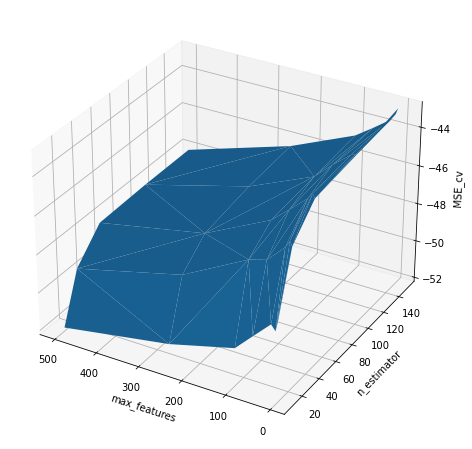

In [233]:
x = df_plot.param_model__max_features
y = df_plot.param_model__n_estimators
z = df_plot.mean_test_score
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('max_features')
ax.set_ylabel('n_estimator')
ax.set_zlabel('MSE_cv')
ax.plot_trisurf(x,y,z);

### Out of bag dataset

### Export best model using pkl

In [234]:
best_pipe = grid_search.best_estimator_

In [235]:
path = '../model/rf_best.pkl'

In [236]:
dump(best_pipe,path)

['../model/rf_best.pkl']

# Test best model on test

## Import best Model from pkl

In [237]:
path = '../model/rf_best.pkl'

In [238]:
best_rf = load(path)

In [239]:
best_rf.score(processed_train_predictors,annee_train)

0.9822997916030907

In [240]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [241]:
process_test_predictors = preprocess_pipeline.transform(test_predictors)

In [242]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

42.003848618190176

In [243]:
best_pipe.score(process_test_predictors,annee_test)

0.8699170040137361

# Naive model (mean or median)

In [58]:
mean_annee = annee_train.mean()
mean_annee

1989.7358656854537

In [59]:
len_train = len(annee_train)

In [60]:
predict_train_annee = np.full((len_train,),mean_annee)

In [61]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(mse_train)

318.24169474809895


In [62]:
len_test = len(annee_test)

In [63]:
predict_test_annee = np.full((len_test,),mean_annee)

In [64]:
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(mse_test)

322.9458306479975


In [65]:
med_annee = annee_train.median()
med_annee

1986.0

In [66]:
predict_train_annee = np.full((len_train,),med_annee)
predict_test_annee = np.full((len_test,),med_annee)

In [67]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(f'train median naive {mse_train}')
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(f'test median naive {mse_train}')

train median naive 332.1983871678491
test median naive 332.1983871678491


## Naive with normal distribution

In [69]:
mean_annee = annee_train.mean()
sd_annee = annee_train.std()

In [71]:
predict_train_annee = np.random.normal(loc=mean_annee,scale=sd_annee,size = len(annee_train))
predict_test_annee = np.random.normal(loc=mean_annee,scale=sd_annee,size = len(annee_test))

In [72]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(f'train mean+sd naive {mse_train}')
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(f'test mean+sd naive {mse_train}')

train mean+sd naive 628.2110973002957
test mean+sd naive 628.2110973002957


c'est encore pire :) mais la distribution normale n'est sans doute pas la plus appropriée

<AxesSubplot:ylabel='Frequency'>

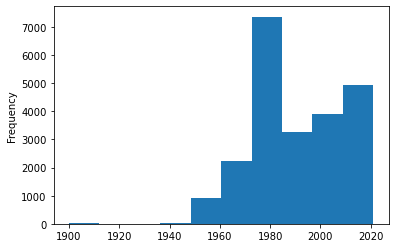

In [ ]:
annee_train.plot(kind='hist')